In [1]:
import os
import cv2
import pathlib
import tensorflow as tf
from tensorflow.keras import layers, Model
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import f1_score, recall_score, precision_score
from tensorflow.keras.applications import VGG16
from scipy.linalg import sqrtm
from sklearn.metrics.pairwise import polynomial_kernel

2024-08-27 08:17:55.834999: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-27 08:17:55.835041: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-27 08:17:55.836675: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-27 08:17:55.845345: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
os.environ['TF_GPU_ALLOCATOR'] = 'cuda_malloc_async'

In [3]:
%env CUDA_DEVICE_ORDER=PCI_BUS_ID
%env CUDA_VISIBLE_DEVICES=2,3

env: CUDA_DEVICE_ORDER=PCI_BUS_ID
env: CUDA_VISIBLE_DEVICES=2,3


In [4]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

In [5]:
class ReadDataset:
    def __init__(self, datasetpath, labels, image_shape):
        self.datasetpath = datasetpath
        self.labels = labels
        self.image_shape = image_shape
    def returListImages(self,):
        self.images = []
        for label in self.labels:
            self.images.append(list(pathlib.Path(os.path.join(self.datasetpath,
                                                              label)).glob('*.*')))
    def readImages(self,):
        self.returListImages()
        self.finalImages = []
        labels = []
        for label in range(len(self.labels)):
            for img in self.images[label]:
                img = cv2.imread(str(img), cv2.IMREAD_GRAYSCALE)
                if img is None:
                    continue
                img = cv2.resize(img , self.image_shape[:2])
                img  = img/255
                img = np.expand_dims(img, axis=-1)  # Add channel dimension to get shape (64, 64, 1)
                self.finalImages.append(img)
                labels.append(label)
        images = np.array(self.finalImages)
        labels = np.array(labels)
        return images, labels

In [6]:
readDatasetObject = ReadDataset('train',
                               ['NORMAL', 'PNEUMONIA'],
                               (64, 64))
images, labels = readDatasetObject.readImages()
images.shape, labels.shape

((5216, 64, 64, 1), (5216,))

In [7]:
class CVAE(Model):
    def __init__(self, latent_dim, num_classes, input_shape):
        super(CVAE, self).__init__()
        self.latent_dim = latent_dim
        self.num_classes = num_classes

        # Encoder network
        self.encoder_inputs = layers.Input(shape=(input_shape[0], input_shape[1], 1))
        self.label_inputs = layers.Input(shape=(num_classes,))
        
        x = layers.Conv2D(32, (3, 3), activation='relu', strides=2, padding='same')(self.encoder_inputs)
        x = layers.Conv2D(64, (3, 3), activation='relu', strides=2, padding='same')(x)
        x = layers.Flatten()(x)
        x = layers.Concatenate()([x, self.label_inputs])
        x = layers.Dense(128, activation='relu')(x)
        
        self.z_mean = layers.Dense(latent_dim)(x)
        self.z_log_var = layers.Dense(latent_dim)(x)

        # Decoder network
        self.decoder_inputs = layers.Input(shape=(latent_dim,))
        self.decoder_labels = layers.Input(shape=(num_classes,))
        x = layers.Concatenate()([self.decoder_inputs, self.decoder_labels])
        x = layers.Dense(16 * 16 * 64, activation='relu')(x)
        x = layers.Reshape((16, 16, 64))(x)
        x = layers.Conv2DTranspose(64, (3, 3), activation='relu', strides=2, padding='same')(x)
        x = layers.Conv2DTranspose(32, (3, 3), activation='relu', strides=2, padding='same')(x)
        decoder_outputs = layers.Conv2DTranspose(1, (3, 3), activation='sigmoid', padding='same')(x)

        self.encoder = Model([self.encoder_inputs, self.label_inputs], [self.z_mean, self.z_log_var])
        self.decoder = Model([self.decoder_inputs, self.decoder_labels], decoder_outputs)

    def sample(self, eps=None):
        if eps is None:
            eps = tf.random.normal(shape=(self.latent_dim,))
        return self.decode(eps, apply_sigmoid=True)

    def encode(self, x, labels):
        z_mean, z_log_var = self.encoder([x, labels])
        eps = tf.random.normal(shape=z_mean.shape)
        z = z_mean + tf.exp(0.5 * z_log_var) * eps
        return z, z_mean, z_log_var

    def decode(self, z, labels, apply_sigmoid=False):
        logits = self.decoder([z, labels])
        if apply_sigmoid:
            probs = tf.sigmoid(logits)
            return probs
        return logits

    def call(self, inputs):
        x, labels = inputs
        z, z_mean, z_log_var = self.encode(x, labels)
        reconstructed = self.decode(z, labels)
        return reconstructed, z_mean, z_log_var

# Example usage
latent_dim = 16
num_classes = 2
input_shape = (64, 64)

cvae = CVAE(latent_dim, num_classes, input_shape)

2024-08-27 08:18:23.092275: I tensorflow/core/common_runtime/gpu/gpu_process_state.cc:236] Using CUDA malloc Async allocator for GPU: 0
2024-08-27 08:18:23.092886: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 12304 MB memory:  -> device: 0, name: Tesla V100-SXM2-16GB, pci bus id: 0000:3d:00.0, compute capability: 7.0
2024-08-27 08:18:23.093377: I tensorflow/core/common_runtime/gpu/gpu_process_state.cc:236] Using CUDA malloc Async allocator for GPU: 1
2024-08-27 08:18:23.093797: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 8100 MB memory:  -> device: 1, name: Tesla V100-SXM2-16GB, pci bus id: 0000:3e:00.0, compute capability: 7.0


In [8]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.optimizers import Adam

# Loss function
def compute_loss(model, x, labels):
    z, z_mean, z_log_var = model.encode(x, labels)
    x_reconstructed = model.decode(z, labels)
    reconstruction_loss = tf.reduce_mean(tf.reduce_sum(tf.keras.losses.binary_crossentropy(x, x_reconstructed), axis=(1, 2)))
    kl_loss = -0.5 * tf.reduce_mean(tf.reduce_sum(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var), axis=1))
    return reconstruction_loss + kl_loss

# Training step
@tf.function
def train_step(model, x, labels, optimizer):
    with tf.GradientTape() as tape:
        loss = compute_loss(model, x, labels)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

# Convert labels to one-hot encoding
def one_hot_encode_labels(labels, num_classes):
    return tf.one_hot(labels, num_classes)

# Prepare the dataset
images = np.array(images).astype('float32')
labels = one_hot_encode_labels(labels, num_classes)

# Create a TensorFlow dataset
batch_size = 32
dataset = tf.data.Dataset.from_tensor_slices((images, labels)).shuffle(10000).batch(batch_size)

# Optimizer
optimizer = Adam(learning_rate=1e-3)

# Training loop
epochs = 351
for epoch in range(epochs):
    for x_batch, labels_batch in dataset:
        x_batch = tf.convert_to_tensor(x_batch)
        labels_batch = tf.convert_to_tensor(labels_batch)
        train_step(cvae, x_batch, labels_batch, optimizer)
    if epoch %50 == 0:
        print(f'Epoch {epoch} completed')




2024-08-27 08:18:25.636387: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8906
2024-08-27 08:18:26.877567: I external/local_xla/xla/service/service.cc:168] XLA service 0x7f2fc105f840 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-08-27 08:18:26.877596: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): Tesla V100-SXM2-16GB, Compute Capability 7.0
2024-08-27 08:18:26.877605: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (1): Tesla V100-SXM2-16GB, Compute Capability 7.0
2024-08-27 08:18:26.883743: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1724746706.985816  320697 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


Epoch 0 completed
Epoch 50 completed
Epoch 100 completed
Epoch 150 completed
Epoch 200 completed
Epoch 250 completed
Epoch 300 completed
Epoch 350 completed


In [9]:
def calculate_fid(real_images, generated_images):
    # Load pre-trained VGG16 model
    vgg_model = VGG16(include_top=False, pooling='avg', input_shape=(64, 64, 3))
    
    # Get the activations from the model for real and generated images
    act_real = vgg_model.predict(real_images)
    act_gen = vgg_model.predict(generated_images)

    # Calculate the mean and covariance of the activations
    mu_real, sigma_real = np.mean(act_real, axis=0), np.cov(act_real, rowvar=False)
    mu_gen, sigma_gen = np.mean(act_gen, axis=0), np.cov(act_gen, rowvar=False)

    # Calculate FID score
    ssdiff = np.sum((mu_real - mu_gen)**2.0)
    covmean = sqrtm(sigma_real.dot(sigma_gen))
    
    # Numerical error can occur in sqrtm, so check if the result is complex
    if np.iscomplexobj(covmean):
        covmean = covmean.real

    fid = ssdiff + np.trace(sigma_real + sigma_gen - 2.0 * covmean)
    return fid
def calculate_kid(real_images, generated_images):
    # Load pre-trained VGG16 model
    vgg_model = VGG16(include_top=False, pooling='avg', input_shape=(64, 64, 3))
    
    # Get the activations from the model for real and generated images
    act_real = vgg_model.predict(real_images)
    act_gen = vgg_model.predict(generated_images)
    
    # Compute polynomial kernels
    kernel_real = polynomial_kernel(act_real)
    kernel_gen = polynomial_kernel(act_gen)
    kernel_cross = polynomial_kernel(act_real, act_gen)
    
    m = len(real_images)
    n = len(generated_images)
    
    # Calculate KID score
    kid = (np.sum(kernel_real) / (m * m)) + (np.sum(kernel_gen) / (n * n)) - (2 * np.sum(kernel_cross) / (m * n))
    return kid
def convert_grayscale_to_rgb(images):
    # Convert numpy array to TensorFlow tensor
    images_tensor = tf.convert_to_tensor(images)
    # Convert grayscale images to RGB
    return tf.image.grayscale_to_rgb(images_tensor)

2024-08-27 08:28:47.901794: E external/local_xla/xla/stream_executor/gpu/gpu_cudamallocasync_allocator.cc:306] gpu_async_0 cuMemAllocAsync failed to allocate 8494152208 bytes: CUDA error: out of memory (CUDA_ERROR_OUT_OF_MEMORY)
 Reported by CUDA: Free memory/Total memory: 1093337088/16928342016
2024-08-27 08:28:47.901825: E external/local_xla/xla/stream_executor/gpu/gpu_cudamallocasync_allocator.cc:311] Stats: Limit:                     12902400000
InUse:                      7353406701
MaxInUse:                  10210890989
NumAllocs:                     6065090
MaxAllocSize:               6033028112
Reserved:                            0
PeakReserved:                        0
LargestFreeBlock:                    0

2024-08-27 08:28:47.901839: E external/local_xla/xla/stream_executor/gpu/gpu_cudamallocasync_allocator.cc:63] Histogram of current allocation: (allocation_size_in_bytes, nb_allocation_of_that_sizes), ...;
2024-08-27 08:28:47.901845: E external/local_xla/xla/stream_executo

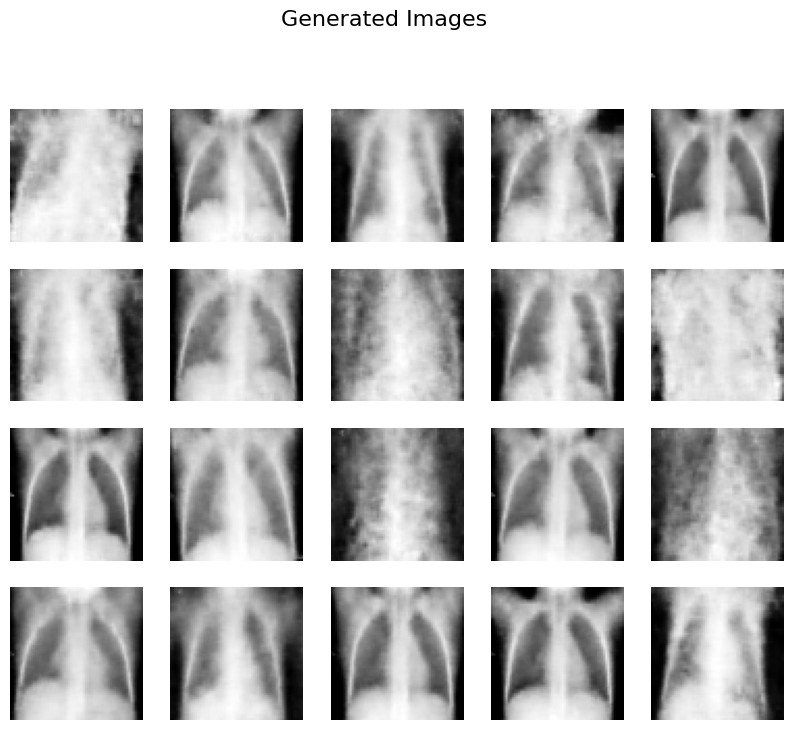

106/106 [==============================] - 1s 6ms/step
FID Score: 25.530058025274997
KID Score: 0.18168624182087623


In [10]:
def plot_images(images, num_images=20, image_size=(64, 64), title="Generated Images"):
    # Calculate the grid size
    grid_size = int(np.ceil(np.sqrt(num_images)))
    
    # Create the plot
    plt.figure(figsize=(grid_size * 2, grid_size * 2))
    
    for i in range(num_images):
        ax = plt.subplot(grid_size, grid_size, i + 1)
        plt.imshow(images[i], cmap='gray')
        plt.axis('off')
    
    if title:
        plt.suptitle(title, fontsize=16)
    
    plt.show()

# Generate synthetic images
latent_vectors = np.random.normal(size=(3389, latent_dim))  # Generate random latent vectors
newlabels = tf.keras.utils.to_categorical(np.random.choice([0, 1], size = (3389, )), num_classes = 2)


# Generate synthetic images using the decoder from the CVAE model
generated_images = cvae.decode(latent_vectors, newlabels, apply_sigmoid=True)

plot_images(generated_images)

# Convert grayscale images to RGB
real_images_rgb = convert_grayscale_to_rgb(images)
generated_images_rgb = convert_grayscale_to_rgb(generated_images)

# Calculate FID and KID scores
fid_score = calculate_fid(real_images_rgb, generated_images_rgb)
kid_score = calculate_kid(real_images_rgb, generated_images_rgb)

print(f'FID Score: {fid_score}')
print(f'KID Score: {kid_score}')





In [11]:
# Convert TensorFlow tensors to NumPy arrays if necessary
#generated_images = generated_images.numpy()
basemodel = tf.keras.applications.VGG16(weights = None, input_shape = (64, 64, 1),
                                        pooling = 'max', include_top = False)
x = layers.Dropout(0.4)(basemodel.output)
x = layers.Dense(128,)(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU(alpha = 0.2)(x)
x = layers.Dropout(0.4)(x)
x = layers.Dense(32,)(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU(alpha = 0.2)(x)
x = layers.Dropout(0.4)(x)
x = layers.Dense(1, activation = 'sigmoid')(x)
m = tf.keras.models.Model(inputs = basemodel.input, outputs = x)
m.compile(loss = 'binary_crossentropy', optimizer = tf.keras.optimizers.Adam(learning_rate = 0.00002))
m.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 64, 64, 1)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 64, 64, 64)        640       
                                                                 
 block1_conv2 (Conv2D)       (None, 64, 64, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 32, 32, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 32, 32, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 32, 32, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 16, 16, 128)       0   

In [12]:
history = m.fit(generated_images, np.argmax(newlabels, axis = 1),
                epochs = 60, batch_size = 64,
                validation_split = 0.2,
                callbacks = [tf.keras.callbacks.EarlyStopping(patience = 3, monitor = 'val_loss', mode = 'min',
                                                              restore_best_weights = True)])

Epoch 1/60
43/43 [==============================] - 12s 86ms/step - loss: 0.7672 - val_loss: 0.6930
Epoch 2/60
43/43 [==============================] - 2s 38ms/step - loss: 0.6916 - val_loss: 0.6929
Epoch 3/60
43/43 [==============================] - 2s 37ms/step - loss: 0.5953 - val_loss: 0.6918
Epoch 4/60
43/43 [==============================] - 2s 37ms/step - loss: 0.3811 - val_loss: 0.6865
Epoch 5/60
43/43 [==============================] - 2s 39ms/step - loss: 0.2489 - val_loss: 0.6798
Epoch 6/60
43/43 [==============================] - 2s 45ms/step - loss: 0.1798 - val_loss: 0.6599
Epoch 7/60
43/43 [==============================] - 2s 42ms/step - loss: 0.1326 - val_loss: 0.6304
Epoch 8/60
43/43 [==============================] - 2s 39ms/step - loss: 0.1148 - val_loss: 0.5873
Epoch 9/60
43/43 [==============================] - 2s 41ms/step - loss: 0.1000 - val_loss: 0.5356
Epoch 10/60
43/43 [==============================] - 2s 38ms/step - loss: 0.0901 - val_loss: 0.5233
Epoch 11

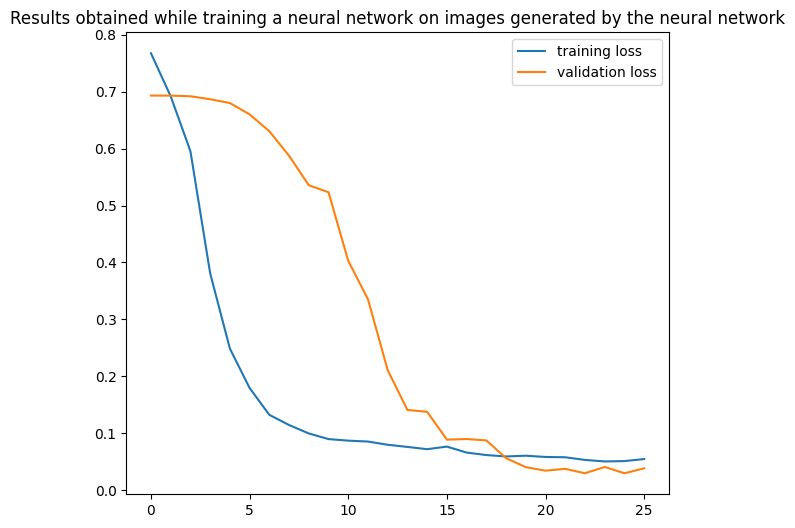

In [13]:
plt.figure(figsize = (7, 6))
plt.plot(history.history['loss'], label = 'training loss')
plt.plot(history.history['val_loss'], label = 'validation loss')
plt.title('Results obtained while training a neural network on images generated by the neural network')
plt.legend()

In [14]:
labels = np.argmax(labels, axis=1)  # Convert one-hot to binary labels (0 or 1)

In [15]:
images.shape,labels.shape

((5216, 64, 64, 1), (5216,))

In [16]:
m.evaluate(images, labels)

163/163 [==============================] - 1s 8ms/step - loss: 0.5447


0.5447469353675842

In [17]:
y_pred = tf.squeeze(m.predict(images))
y_pred.shape

163/163 [==============================] - 2s 6ms/step


TensorShape([5216])

In [18]:
y_pred = y_pred >= 0.5
y_pred = np.array(y_pred, dtype = 'int32')
y_pred

array([0, 0, 0, ..., 1, 1, 0], dtype=int32)

In [19]:
accuracy_score(y_pred, labels)*100

81.42254601226993

In [20]:
print(classification_report(y_pred, labels))

              precision    recall  f1-score   support

           0       1.00      0.58      0.73      2304
           1       0.75      1.00      0.86      2912

    accuracy                           0.81      5216
   macro avg       0.87      0.79      0.80      5216
weighted avg       0.86      0.81      0.80      5216



In [21]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
cm = confusion_matrix(y_pred, labels)
cm

array([[1338,  966],
       [   3, 2909]])

In [22]:
import pandas as pd
cmObject = pd.DataFrame(cm , index = ['NORMAL', 'PNEUMONIA'],
                        columns = ['NORMAL', 'PNEUMONIA'])
cmObject.head()

,NORMAL,PNEUMONIA
NORMAL,1338,966
PNEUMONIA,3,2909


In [23]:
print('f1_score: {}, recall_score: {}, precision_score: {}'.format(f1_score(y_pred, labels)*100,
                                                                   recall_score(y_pred, labels)*100,
                                                                   precision_score(y_pred, labels)*100))

f1_score: 85.7227051716517, recall_score: 99.89697802197803, precision_score: 75.07096774193548


<Axes: >

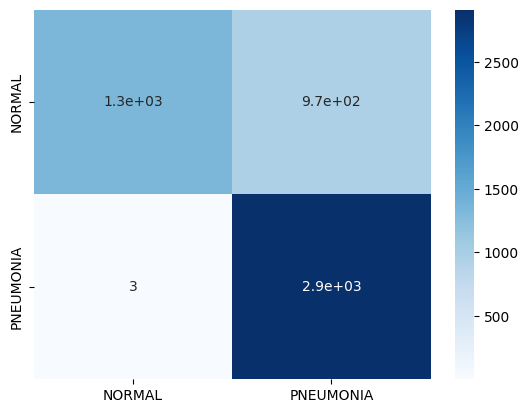

In [24]:
sns.heatmap(cmObject, annot = True, cmap="Blues")